In [1]:
from sklearn import datasets
from PIL import Image
import glob
import pandas as pd
import numpy as np
import random
from plotnine import *

# load data
faces = datasets.fetch_olivetti_faces()
faces.data.shape

(400, 4096)

# Eigenfaces (Using PCA on Black and White Face Images)

In class we looked at an example of **Eigenfaces** that I made for my grandfather's birthday. Here's an anonymized version with a famous face dataset: the olivetti faces.

First, let's load in the data and look at a few of the faces. Note that they're all square, black and white images of faces.

In [2]:
# turn our images into a dataframe of pixel values
faces_df = pd.DataFrame(faces.data)
faces_df.head()

,0,1,2,3,4,5,6,7,8,9,...,4086,4087,4088,4089,4090,4091,4092,4093,4094,4095
0,0.309917,0.367769,0.417355,0.442149,0.528926,0.607438,0.657025,0.677686,0.690083,0.685950,...,0.665289,0.669421,0.652893,0.661157,0.475207,0.132231,0.148760,0.152893,0.161157,0.157025
1,0.454545,0.471074,0.512397,0.557851,0.595041,0.640496,0.681818,0.702479,0.710744,0.702479,...,0.136364,0.157025,0.136364,0.148760,0.152893,0.152893,0.152893,0.152893,0.152893,0.152893
2,0.318182,0.400826,0.491736,0.528926,0.586777,0.657025,0.681818,0.685950,0.702479,0.698347,...,0.074380,0.132231,0.181818,0.136364,0.128099,0.148760,0.144628,0.140496,0.148760,0.152893
3,0.198347,0.194215,0.194215,0.194215,0.190083,0.190083,0.243802,0.404959,0.483471,0.516529,...,0.652893,0.636364,0.657025,0.685950,0.727273,0.743802,0.764463,0.752066,0.752066,0.739669
4,0.500000,0.545455,0.582645,0.623967,0.648760,0.690083,0.694215,0.714876,0.723140,0.731405,...,0.190083,0.161157,0.177686,0.173554,0.177686,0.177686,0.177686,0.177686,0.173554,0.173554


In [3]:
faces_df.shape

(400, 4096)

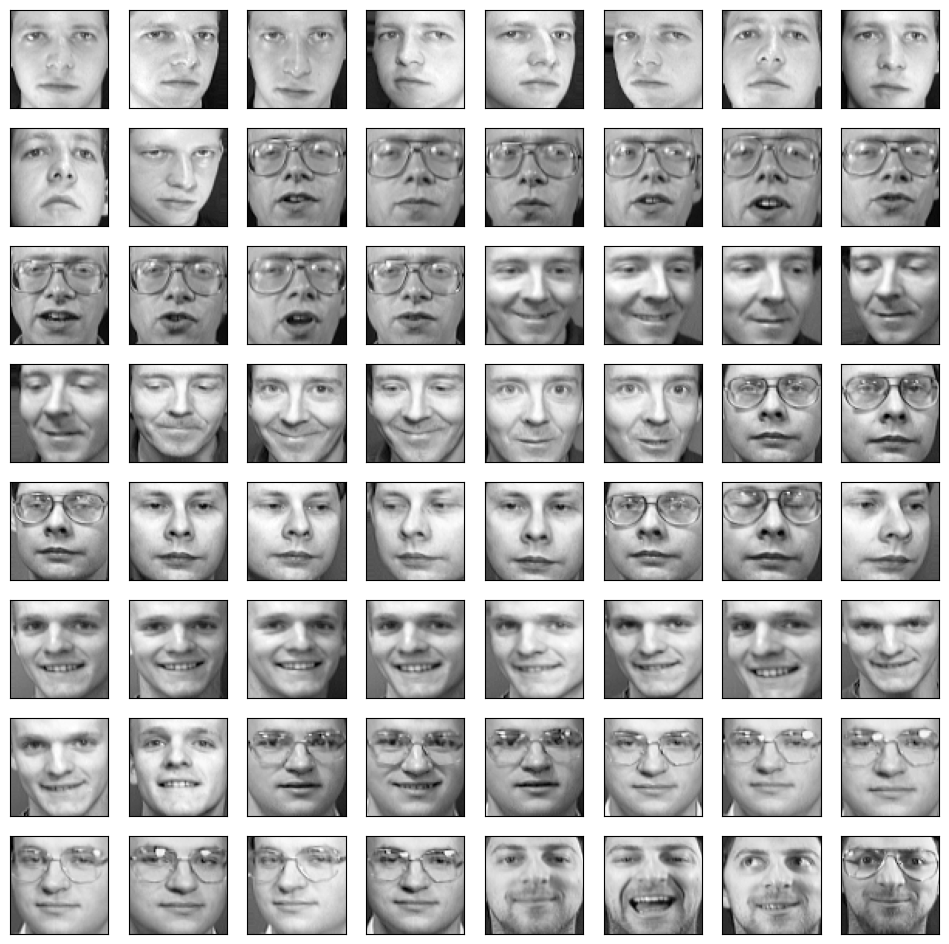

In [4]:
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(12,12))
# plot several images
for i in range(64):
    ax = fig.add_subplot(8,8, i + 1, xticks=[], yticks=[])
    f = faces_df.iloc[i]
    im  = [f[i * 64:(i + 1) * 64] for i in range((len(f) + 64 - 1) // 64 )] 
    ax.imshow(im, cmap=plt.cm.gist_gray)

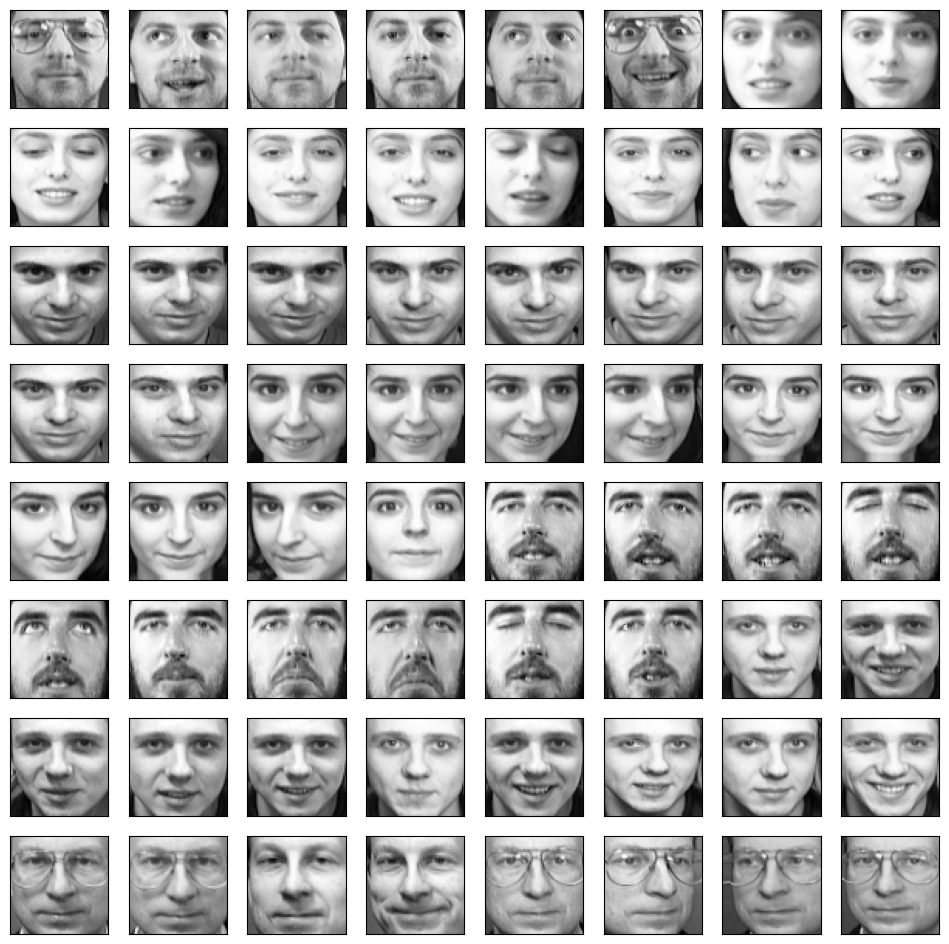

In [5]:
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(12,12))
# plot several images
for i in range(64,128):
    i = i - 64
    ax = fig.add_subplot(8,8, i + 1, xticks=[], yticks=[])
    f = faces_df.iloc[i + 64]
    im  = [f[i * 64:(i + 1) * 64] for i in range((len(f) + 64 - 1) // 64 )] 
    ax.imshow(im, cmap=plt.cm.gist_gray)

## PCA

Now that we've seen the original faces, let's do PCA on them. For these eigenfaces, we'll treat every pixel (there are 4096 pixels in each image) as a feature. Notice that we're not z-scoring because 1. all the pixel values are already on the same scale and 2. we want to represent the colors as values between 0-1.

We're going to use `sklearn`'s `PCA` function and fit our model to extract 25 components out of 4096. 

In [6]:
from sklearn import decomposition

n = 25 # number of components to extract
pca = decomposition.PCA(n_components=n, whiten=True)
pca.fit(faces_df)

PCA(n_components=25, whiten=True)

## The Mean and Variance Faces

Remember that PCA uses eigendecomposition to decompose the **covariance** matrix that shows how related all our 4096 variables are. Here are some visualizations of the mean face (which shows the mean color value from each pixel) and the variance face (which shows the variance of each pixel.)


### Mean Face

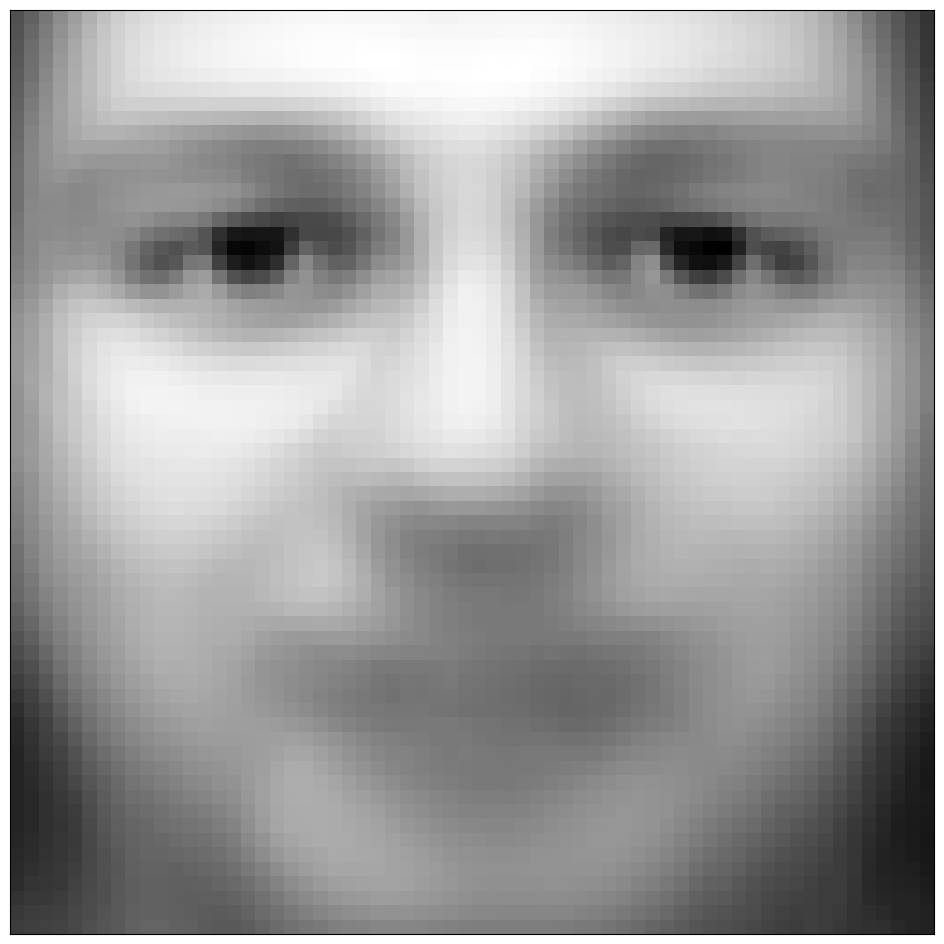

In [7]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(1, 1, 1, xticks=[], yticks=[])
ax.imshow(pca.mean_.reshape((64,64)),
           cmap=plt.cm.gist_gray)


### Variance Face

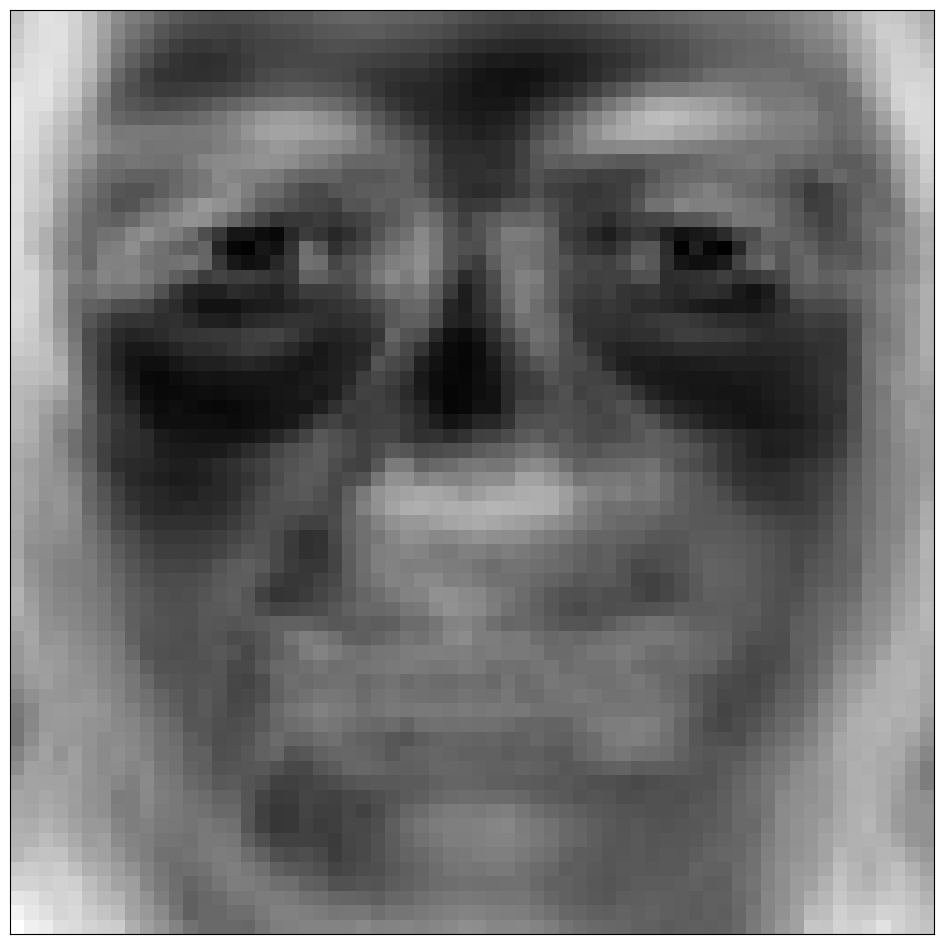

In [8]:
pixel_var = np.array(faces_df.std(axis = 0)).reshape((64,64))
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(1, 1, 1, xticks=[], yticks=[])
ax.imshow(pixel_var,
           cmap=plt.cm.gist_gray)

### Correlation Plot

Here we see a plot of the covariance matrix for our 4096 pixel columns

<Axes: >

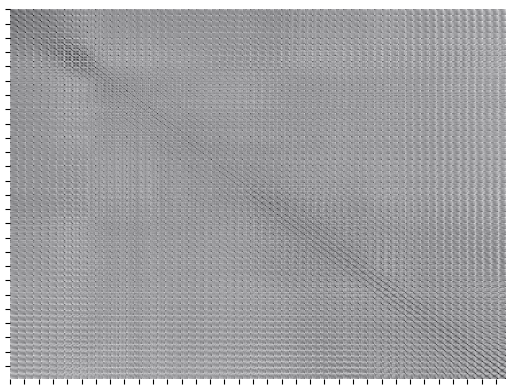

In [9]:
import seaborn as sns

cmap = sns.cubehelix_palette(50, hue=0.05, rot=0, light=0.9, dark=0)
g = sns.heatmap(faces_df.cov(), cmap = cmap, cbar = False)
g.set(xticklabels = [], yticklabels = [])
g

## The EigenFaces

The word "EigenFaces" typically refers to the different principal components generated by applying PCA to the face images. 

Here are the first 25 principal components, re-shaped into an image. Take a loot and notice what features each component seems to represent (e.g. glasses, smiles, noses, eyebrows.)

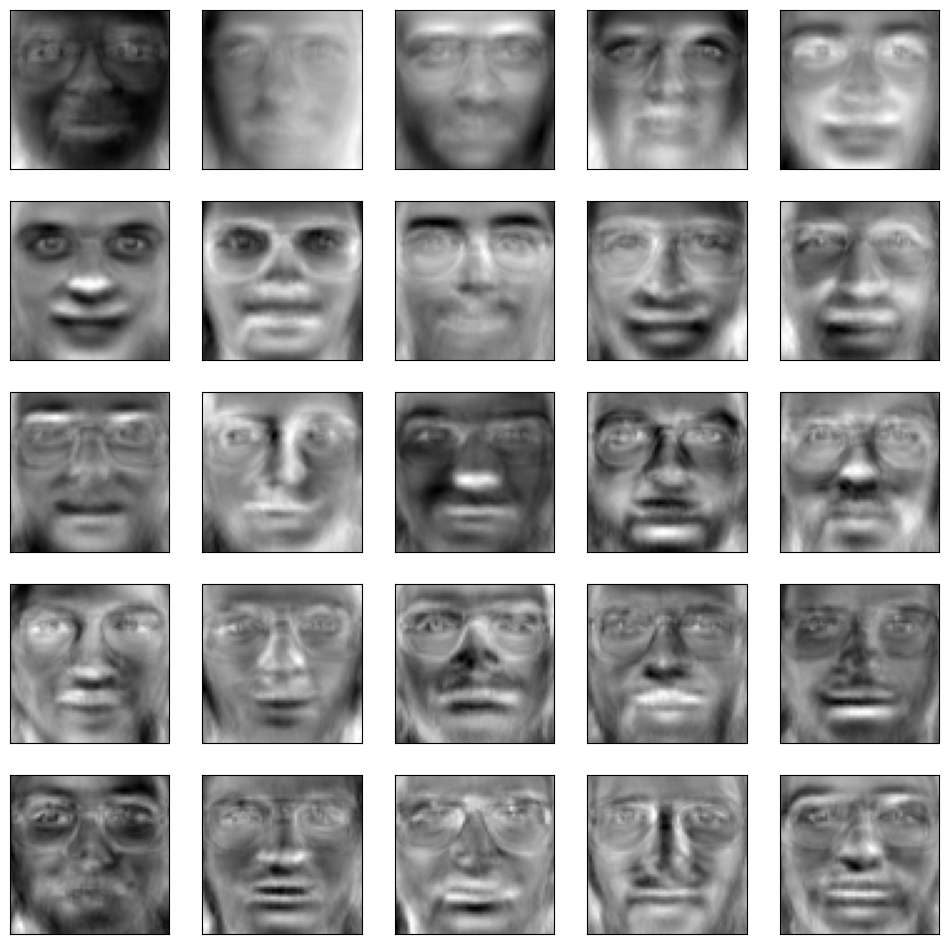

In [10]:
fig = plt.figure(figsize=(12,12))
for i in range(25):
    ax = fig.add_subplot(5,5, i + 1, xticks=[], yticks=[])
    ax.imshow(pca.components_[i].reshape(faces.images[0].shape),
              cmap=plt.cm.gist_gray)

## Cumulative Variance Plot

Each of these eigenfaces (aka principal components) explains *some* amount of variation in the faces, with the first eigenface/PC explaining the most variance, the second eigenface/PC explaining the second most...etc.

Here's a cumulative variance plot that shows the amount of variance explained by each eigenface. The first face explains almost 25% of the variance!

In [11]:
pcaDF = pd.DataFrame({"expl_var" : pca.explained_variance_ratio_, "pc": range(1,n+1),
                      "cum_var": pca.explained_variance_ratio_.cumsum()})

# add zeros
pcaDF = pcaDF.append(pd.DataFrame({"expl_var" : [0], "pc": [0], "cum_var": [0]}))

/var/folders/j2/4wwct0g14b9cg2dccwny_5ch0000gn/T/ipykernel_72100/1365523354.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


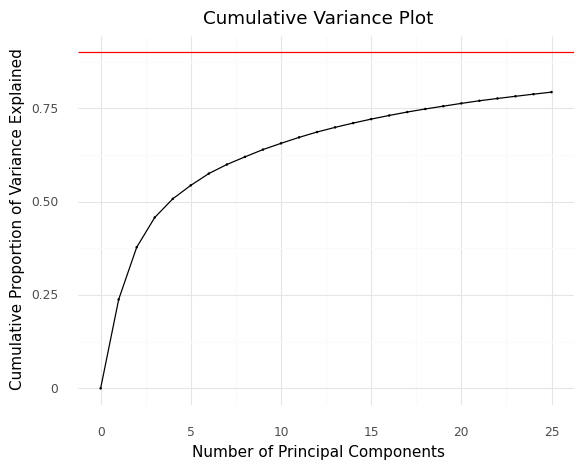

In [12]:
fig, plot = (ggplot(pcaDF, aes(x = "pc", y = "cum_var")) + geom_line() + geom_point(size = 0.01) + theme_minimal() +
labs(x = "Number of Principal Components", y = "Cumulative Proportion of Variance Explained",
title = "Cumulative Variance Plot") +
geom_hline(yintercept = 0.9, color = "red")).draw(show=False, return_ggplot=True)

## Visualizing Compressed Faces

While PCA will generate 4096 Principal Components, we're only grabbing the first 25, which means we're losing *some* information from the images. But our cumulative variance plot says that the first 25 eigenfaces/components give more than 75% of the original information/variance in the data! So the pictures will still hopefully be recognizable. Let's see!

In [13]:
# convert from raw pixel values to 25 PCs
faces_df_pca = pca.transform(faces_df)


In [14]:
# convert from 25 PCs to raw pixels
faces_df_compressed_photo = pca.inverse_transform(faces_df_pca)

### Faces with 25/4096 PCs

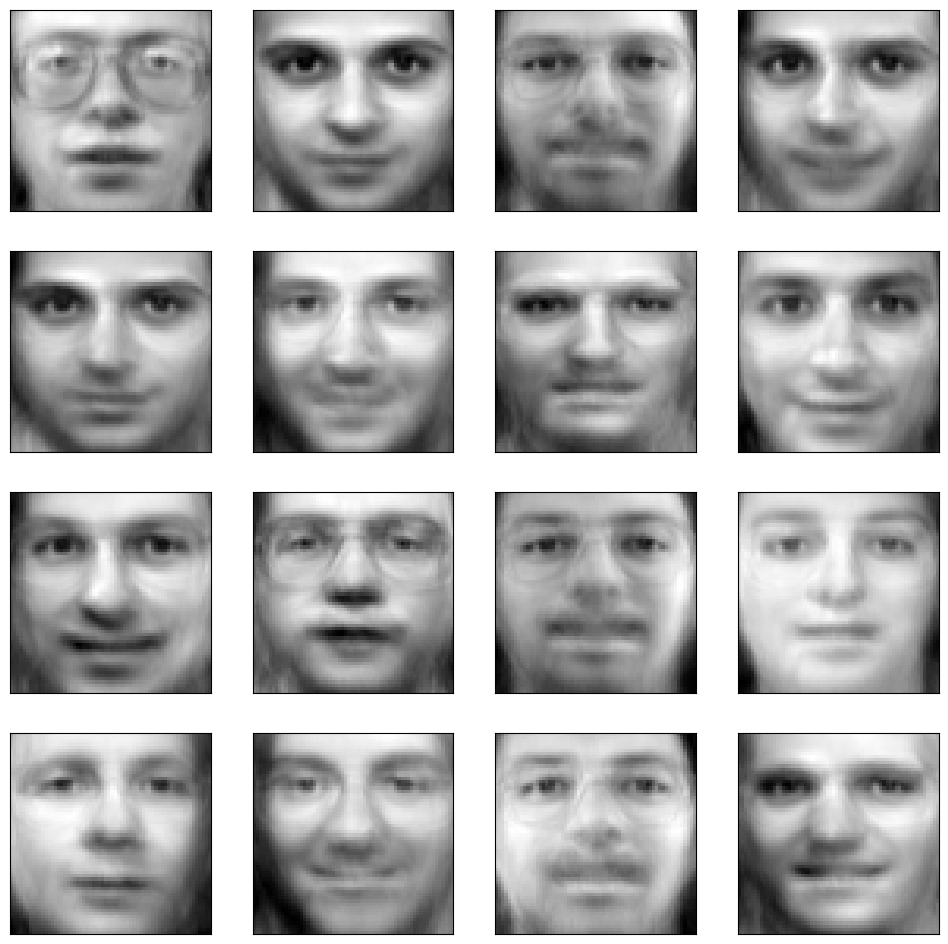

In [15]:
fig = plt.figure(figsize=(12,12))
# faces_16 = np.random.choice(range(128), size = 16, replace = False)
faces_16 = [ 19,  83,  63,  86,  85,  26,  47,  90, 123,  32,  64,  74,  34, 27,  66,  45]
for i in range(16):
    ax = fig.add_subplot(4,4, i + 1, xticks=[], yticks=[])
    ax.imshow(faces_df_compressed_photo[faces_16[i]].reshape((64,64)), cmap=plt.cm.gist_gray)

### Original Faces

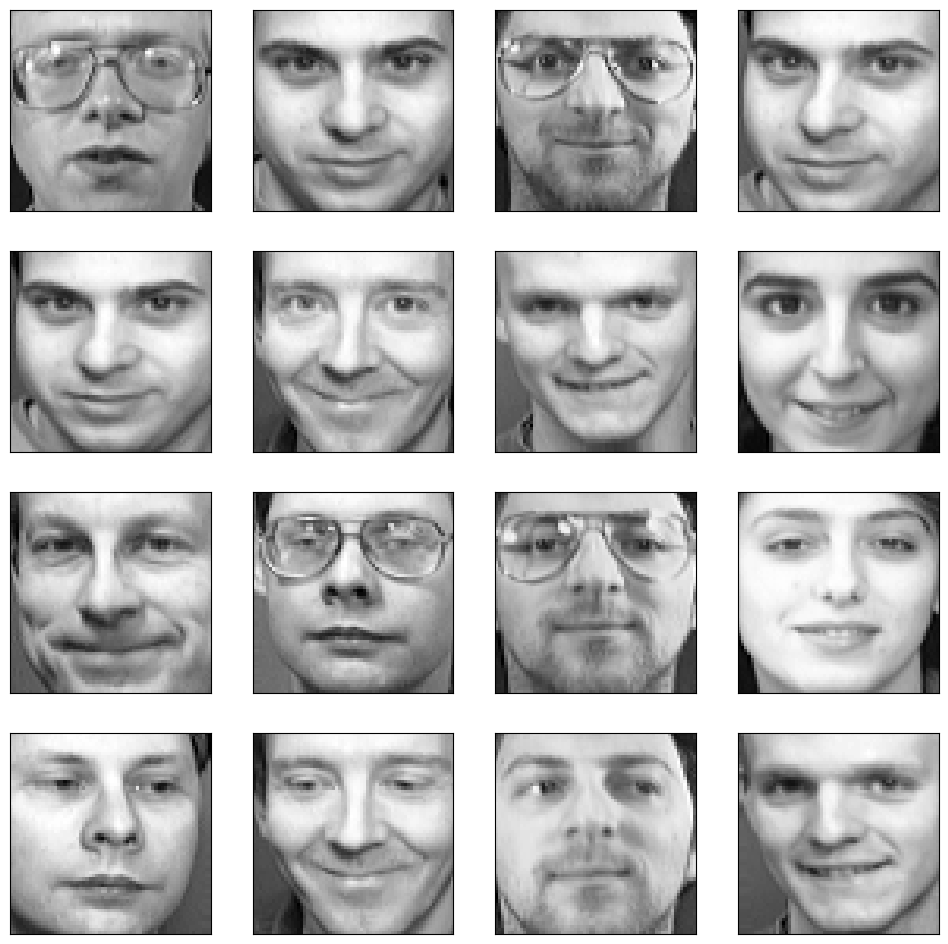

In [16]:
fig = plt.figure(figsize=(12,12))
for i in range(16):
    ax = fig.add_subplot(4,4, i + 1, xticks=[], yticks=[])
    ax.imshow(np.array(faces_df.iloc[faces_16[i]]).reshape((64,64)), cmap=plt.cm.gist_gray)


Wow! those still look pretty recognizable!

Let's look at one a little closer.

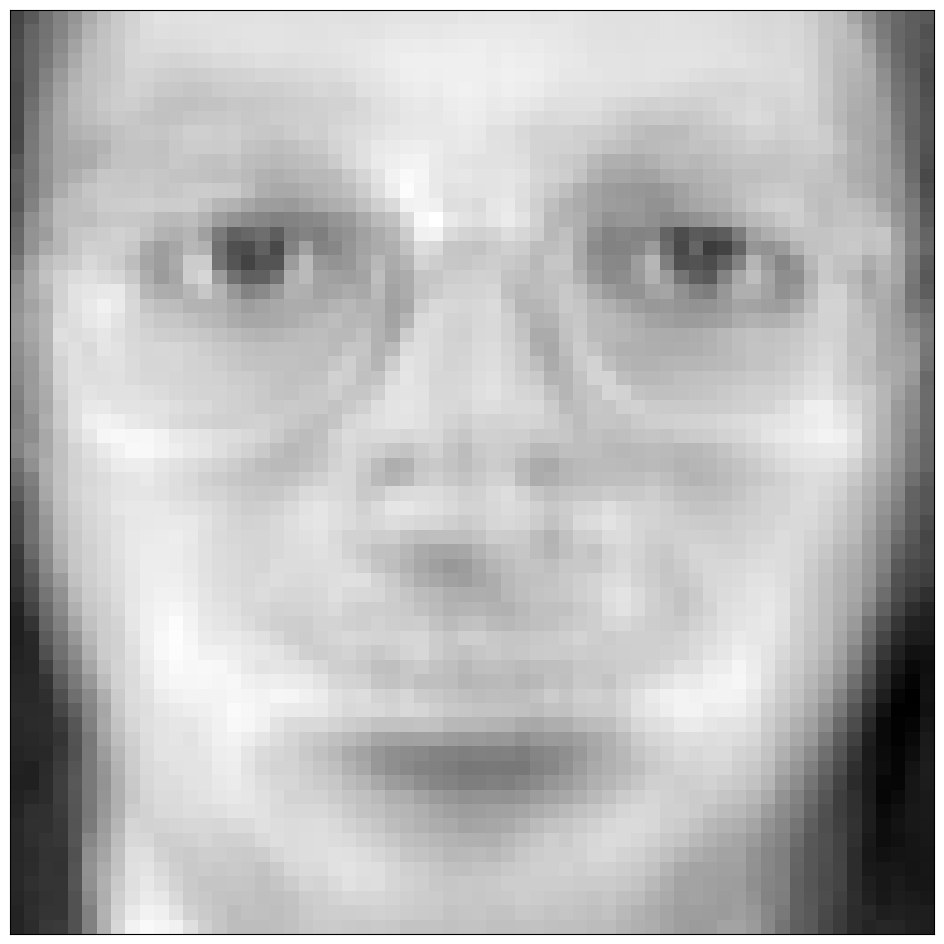

In [17]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(1, 1, 1, xticks=[], yticks=[])
ax.imshow(faces_df_compressed_photo[2].reshape((64,64)), cmap=plt.cm.gist_gray)

## Play Around

Now you can play around with creating re-constructed faces using any number of components (more components: closer to the original photos. less components: more compression).

The variable `n` at the top of each section determines how many principal components to use when reconstructing the faces. The following cell will plot the reconstructed faces!

Try a few out! Try something big like 100, or something small like 2!

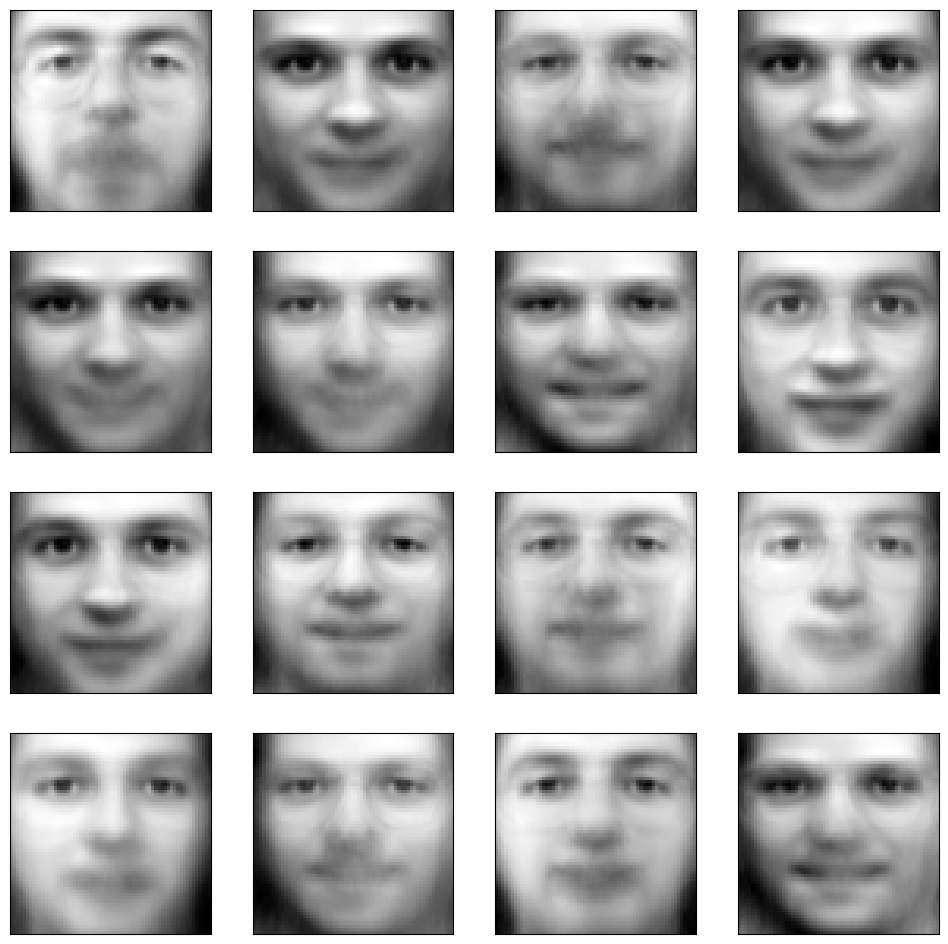

In [18]:
n = 6 # number of components
pca3 = decomposition.PCA(n_components=n, whiten=True)
pca3.fit(faces_df)

faces_df_pca3 = pca3.transform(faces_df)
faces_df_compressed_photo3 = pca3.inverse_transform(faces_df_pca3)

# plot faces
fig = plt.figure(figsize=(12,12))
# faces_16 = np.random.choice(range(128), size = 16, replace = False)
faces_16 = [ 19,  83,  63,  86,  85,  26,  47,  90, 123,  32,  64,  74,  34, 27,  66,  45]
for i in range(16):
    ax = fig.add_subplot(4,4, i + 1, xticks=[], yticks=[])
    ax.imshow(faces_df_compressed_photo3[faces_16[i]].reshape((64,64)), cmap=plt.cm.gist_gray)